In [3]:
import numpy as np
import pandas as pd

In [4]:
from datetime import datetime

start = datetime.now()

In [5]:
def show_df(df):
    print('Rows: {:,} / Cols: {:,}'.format(len(df), len(df.columns)))
    return df.head(3)

def create_dummies(df, column):
    dummies = pd.get_dummies(df[column], prefix=column)
    df[dummies.columns] = dummies

In [6]:
first_day_of_week = 'W-SUN'
inflate_database = False

# Trade

In [7]:
df_trade = pd.read_csv('data/Trade.csv')
df_trade.TradeDateKey = pd.to_datetime(df_trade.TradeDateKey, format='%Y%m%d')
df_trade['original'] = True

In [7]:
if inflate_database:
    df_trade_rev = df_trade[df_trade.CustomerInterest == 1].copy()
    df_trade_rev.BuySell = df_trade_rev.BuySell.apply(lambda v: 'Buy' if v == 'Sell' else 'Sell')
    df_trade['original'] = False
    df_trade_rev.CustomerInterest = 0

In [11]:
if inflate_database:
    df_challenge = pd.read_csv('data/Challenge_20180423.csv')
    df_trade_test = df_challenge[['CustomerIdx', 'IsinIdx', 'BuySell']].copy()
    df_trade_test['TradeDateKey'] = df_trade.TradeDateKey.max()  # coloca na ultima semana
    df_trade_test['original'] = False
    df_trade_test['CustomerInterest'] = 0                      

In [12]:
if inflate_database:
    df_trade = pd.concat([df_trade, df_trade_rev, df_trade_test], ignore_index=True)
df_trade['week_start'] = df_trade.TradeDateKey.dt.to_period(first_day_of_week).dt.start_time 
df_trade.sort_values('TradeDateKey', inplace=True)
df_trade.reset_index(inplace=True, drop=True)

In [13]:
df_trade = df_trade[df_trade.TradeDateKey.dt.year >= 2018]
df_trade.to_csv('data/Trade2.csv', index=False)

In [8]:
show_df(df_trade)

Rows: 6,762,021 / Cols: 9


,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest,original
0,2016-12-07,2789,8478,Sell,653168.0,0.0,Unknown,1.0,True
1,2017-03-29,2574,14562,Buy,1656487.0,0.0,Unknown,1.0,True
2,2017-04-18,2574,4747,Buy,939673.0,0.0,Unknown,1.0,True


## Looking history

In [11]:
df_trade_orig = pd.read_csv('data/Trade.csv')
df_trade_orig.TradeDateKey = pd.to_datetime(df_trade_orig.TradeDateKey, format='%Y%m%d')
df_trade_orig['week_start'] = df_trade_orig.TradeDateKey.dt.to_period(first_day_of_week).dt.start_time

In [12]:
create_dummies(df_trade_orig, 'BuySell')
create_dummies(df_trade_orig, 'TradeStatus')

In [13]:
df_trade_orig.loc[(df_trade_orig.BuySell == 'Buy') & (df_trade_orig.CustomerInterest == 1), 'ExecutedBuy'] = 1
df_trade_orig.loc[(df_trade_orig.BuySell == 'Sell') & (df_trade_orig.CustomerInterest == 1), 'ExecutedSell'] = 1

df_trade_orig.ExecutedBuy.fillna(0, inplace=True)
df_trade_orig.ExecutedSell.fillna(0, inplace=True)

df_trade_orig['ExecutedBalance'] = df_trade_orig.ExecutedBuy - df_trade_orig.ExecutedSell

In [14]:
df_trade_orig.iloc[0]

TradeDateKey             2016-12-07 00:00:00
CustomerIdx                             2789
IsinIdx                                 8478
BuySell                                 Sell
NotionalEUR                           653168
Price                                      0
TradeStatus                          Unknown
CustomerInterest                           1
week_start               2016-12-05 00:00:00
BuySell_Buy                                0
BuySell_Sell                               1
TradeStatus_Done                           0
TradeStatus_Holding                        0
TradeStatus_IOI                            0
TradeStatus_NotTraded                      0
TradeStatus_Unknown                        1
ExecutedBuy                                0
ExecutedSell                               1
ExecutedBalance                           -1
Name: 0, dtype: object

In [15]:
agg_features = ['BuySell_Buy', 'BuySell_Sell', 'TradeStatus_Done', 'TradeStatus_IOI', 'TradeStatus_NotTraded',
                'TradeStatus_Unknown', 'ExecutedBuy', 'ExecutedSell', 'ExecutedBalance']

aggs = {}
for feature in agg_features:
    aggs[feature] = ['sum']

### By Customer + Isin

In [16]:
df_trade_hist = df_trade_orig.groupby(['CustomerIdx', 'IsinIdx', 'week_start']).agg(aggs)
df_trade_hist = df_trade_hist.reset_index()
df_trade_hist.columns = ['.'.join(tup).rstrip('.') for tup in df_trade_hist.columns.values]

show_df(df_trade_hist)

Rows: 6,200,077 / Cols: 12


,CustomerIdx,IsinIdx,week_start,BuySell_Buy.sum,BuySell_Sell.sum,TradeStatus_Done.sum,TradeStatus_IOI.sum,TradeStatus_NotTraded.sum,TradeStatus_Unknown.sum,ExecutedBuy.sum,ExecutedSell.sum,ExecutedBalance.sum
0,0,16471,2017-05-15,1,0,1,0,0,0,1.0,0.0,1.0
1,0,16499,2017-06-05,1,0,1,0,0,0,1.0,0.0,1.0
2,0,20601,2017-06-12,1,0,1,0,0,0,1.0,0.0,1.0


In [17]:
df_trade_hist.sort_values(['CustomerIdx', 'IsinIdx', 'week_start'], inplace=True)

features_agg2 = df_trade_hist.columns.drop(['CustomerIdx', 'IsinIdx', 'week_start'])
df_trade_hist_tmp = df_trade_hist.groupby(['CustomerIdx', 'IsinIdx'])[features_agg2].cumsum()

df_trade_hist[df_trade_hist_tmp.columns] = df_trade_hist_tmp
show_df(df_trade_hist)

Rows: 6,200,077 / Cols: 12


,CustomerIdx,IsinIdx,week_start,BuySell_Buy.sum,BuySell_Sell.sum,TradeStatus_Done.sum,TradeStatus_IOI.sum,TradeStatus_NotTraded.sum,TradeStatus_Unknown.sum,ExecutedBuy.sum,ExecutedSell.sum,ExecutedBalance.sum
0,0,16471,2017-05-15,1,0,1,0,0,0,1.0,0.0,1.0
1,0,16499,2017-06-05,1,0,1,0,0,0,1.0,0.0,1.0
2,0,20601,2017-06-12,1,0,1,0,0,0,1.0,0.0,1.0


In [18]:
df_trade_hist['next_week_start'] = df_trade_hist['week_start'] + pd.Timedelta(days=7)
df_trade_hist.to_csv('data/Trade2_AggHist.csv', index=False)

### By Customer

In [19]:
aggs2 = aggs.copy()
aggs2.update({'IsinIdx': ['count', pd.Series.nunique]})

df_trade_hist2 = df_trade_orig.groupby(['CustomerIdx', 'week_start']).agg(aggs2)
df_trade_hist2 = df_trade_hist2.reset_index()
df_trade_hist2.columns = ['.'.join(tup).rstrip('.') for tup in df_trade_hist2.columns.values]

show_df(df_trade_hist2)

Rows: 137,339 / Cols: 13


,CustomerIdx,week_start,BuySell_Buy.sum,BuySell_Sell.sum,TradeStatus_Done.sum,TradeStatus_IOI.sum,TradeStatus_NotTraded.sum,TradeStatus_Unknown.sum,ExecutedBuy.sum,ExecutedSell.sum,ExecutedBalance.sum,IsinIdx.count,IsinIdx.nunique
0,0,2016-10-10,1.0,0.0,1.0,0,0.0,0.0,1.0,0.0,1.0,1,1
1,0,2016-10-31,0.0,1.0,1.0,0,0.0,0.0,0.0,1.0,-1.0,1,1
2,0,2016-11-07,0.0,3.0,3.0,0,0.0,0.0,0.0,3.0,-3.0,3,2


In [20]:
df_trade_hist2.sort_values(['CustomerIdx', 'week_start'], inplace=True)

features_agg2 = df_trade_hist2.columns.drop(['CustomerIdx', 'week_start'])
df_trade_hist_tmp = df_trade_hist2.groupby(['CustomerIdx'])[features_agg2].cumsum()

df_trade_hist2[df_trade_hist_tmp.columns] = df_trade_hist_tmp
show_df(df_trade_hist2)

Rows: 137,339 / Cols: 13


,CustomerIdx,week_start,BuySell_Buy.sum,BuySell_Sell.sum,TradeStatus_Done.sum,TradeStatus_IOI.sum,TradeStatus_NotTraded.sum,TradeStatus_Unknown.sum,ExecutedBuy.sum,ExecutedSell.sum,ExecutedBalance.sum,IsinIdx.count,IsinIdx.nunique
0,0,2016-10-10,1.0,0.0,1.0,0,0.0,0.0,1.0,0.0,1.0,1,1
1,0,2016-10-31,1.0,1.0,2.0,0,0.0,0.0,1.0,1.0,0.0,2,2
2,0,2016-11-07,1.0,4.0,5.0,0,0.0,0.0,1.0,4.0,-3.0,5,4


In [21]:
df_trade_hist2['next_week_start'] = df_trade_hist2['week_start'] + pd.Timedelta(days=7)
df_trade_hist2.to_csv('data/Trade2_AggHistByCustomer.csv', index=False)

### By Isin

In [22]:
aggs3 = aggs.copy()
aggs3.update({'CustomerIdx': ['count', pd.Series.nunique]})

df_trade_hist3 = df_trade_orig.groupby(['IsinIdx', 'week_start']).agg(aggs3)
df_trade_hist3 = df_trade_hist3.reset_index()
df_trade_hist3.columns = ['.'.join(tup).rstrip('.') for tup in df_trade_hist3.columns.values]

show_df(df_trade_hist3)

Rows: 1,182,984 / Cols: 13


,IsinIdx,week_start,BuySell_Buy.sum,BuySell_Sell.sum,TradeStatus_Done.sum,TradeStatus_IOI.sum,TradeStatus_NotTraded.sum,TradeStatus_Unknown.sum,ExecutedBuy.sum,ExecutedSell.sum,ExecutedBalance.sum,CustomerIdx.count,CustomerIdx.nunique
0,0,2016-02-22,2,0,0.0,0,0,2,2.0,0.0,2.0,2,1
1,0,2016-05-02,0,1,0.0,0,0,1,0.0,1.0,-1.0,1,1
2,0,2016-05-16,0,2,0.0,0,2,0,0.0,2.0,-2.0,2,1


In [23]:
df_trade_hist3.sort_values(['IsinIdx', 'week_start'], inplace=True)

features_agg2 = df_trade_hist3.columns.drop(['IsinIdx', 'week_start'])
df_trade_hist_tmp = df_trade_hist3.groupby(['IsinIdx'])[features_agg2].cumsum()

df_trade_hist3[df_trade_hist_tmp.columns] = df_trade_hist_tmp
show_df(df_trade_hist3)

Rows: 1,182,984 / Cols: 13


,IsinIdx,week_start,BuySell_Buy.sum,BuySell_Sell.sum,TradeStatus_Done.sum,TradeStatus_IOI.sum,TradeStatus_NotTraded.sum,TradeStatus_Unknown.sum,ExecutedBuy.sum,ExecutedSell.sum,ExecutedBalance.sum,CustomerIdx.count,CustomerIdx.nunique
0,0,2016-02-22,2,0,0.0,0,0,2,2.0,0.0,2.0,2,1
1,0,2016-05-02,2,1,0.0,0,0,3,2.0,1.0,1.0,3,2
2,0,2016-05-16,2,3,0.0,0,2,3,2.0,3.0,-1.0,5,3


In [24]:
df_trade_hist3['next_week_start'] = df_trade_hist3['week_start'] + pd.Timedelta(days=7)
df_trade_hist3.to_csv('data/Trade2_AggHistByIsin.csv', index=False)

## Trade By Week

In [25]:
df_trade_agg = df_trade.groupby(['week_start', 'CustomerIdx', 'IsinIdx', 'BuySell']).CustomerInterest.max()
df_trade_agg = df_trade_agg.to_frame().reset_index()
show_df(df_trade_agg)

Rows: 1,477,183 / Cols: 5


,week_start,CustomerIdx,IsinIdx,BuySell,CustomerInterest
0,2018-01-01,2,17040,Buy,1.0
1,2018-01-01,2,17040,Sell,0.0
2,2018-01-01,9,3428,Buy,1.0


In [26]:
df_trade_agg.to_csv('data/Trade2_ByWeek.csv', index=False)

# Challenge

In [27]:
df_challenge = pd.read_csv('data/Challenge_20180423.csv')
df_challenge.DateKey = pd.to_datetime(df_challenge.DateKey, format='%Y%m%d')
df_challenge['week_start'] = df_challenge.DateKey.dt.to_period(first_day_of_week).dt.start_time

df_challenge.sort_values('DateKey', inplace=True)

In [28]:
df_challenge.to_csv('data/Challenge2.csv', index=False)

In [29]:
show_df(df_challenge)

Rows: 484,758 / Cols: 7


,PredictionIdx,DateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,week_start
0,a1e0d80784,2018-04-23,1856,13323,Buy,NaN,2018-04-23
323179,ce7a1e3f46,2018-04-23,703,24709,Sell,NaN,2018-04-23
323178,37363eb0b5,2018-04-23,2276,24082,Sell,NaN,2018-04-23


# Customer

In [30]:
df_customer = pd.read_csv('data/Customer.csv')
df_customer.fillna('', inplace=True)

In [31]:
df_customer.to_csv('data/Customer2.csv', index=False)

In [32]:
show_df(df_customer)

Rows: 3,471 / Cols: 5


,CustomerIdx,Sector,Subsector,Region,Country
0,2975,Banks and Intermediaries,Bank,Americas,BARBADOS
1,1594,Asset Managers & Hedge Funds,,Americas,BERMUDA
2,399,Corporation,Corp - Comm. & Prof. Services,Americas,BERMUDA


# Isin

In [33]:
df_isin = pd.read_csv('data/Isin.csv')
df_isin.IssueDateKey = pd.to_datetime(df_isin.IssueDateKey, format='%Y%m%d')
df_isin.ActualMaturityDateKey = pd.to_datetime(df_isin.ActualMaturityDateKey, format='%Y%m%d')

In [34]:
df_isin.to_csv('data/Isin2.csv', index=False)

In [35]:
show_df(df_isin)

Rows: 27,411 / Cols: 17


,IsinIdx,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,0,238,2038-12-31,2005-11-29,GOV,USD,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,NR,Government,Sovereign,Domestic,1.246002e+09,STEP CPN
1,1,238,2033-12-31,2005-11-29,GOV,USD,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,NR,Government,Sovereign,Domestic,4.901086e+09,FIXED
2,2,238,2033-12-31,2005-11-29,GOV,ARS,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,NR,Government,Sovereign,Domestic,1.501245e+10,FIXED


# Market

In [36]:
df_market = pd.read_csv('data/Market.csv')
df_market.DateKey = pd.to_datetime(df_market.DateKey, format='%Y%m%d')
df_market['week_start'] = df_market.DateKey.dt.to_period(first_day_of_week).dt.start_time

In [37]:
df_market.to_csv('data/Market2.csv', index=False)

In [38]:
show_df(df_market)

Rows: 9,867,747 / Cols: 6


,IsinIdx,DateKey,Price,Yield,ZSpread,week_start
0,1,2016-01-01,104.250,7.835,5.505,2015-12-28
1,7,2016-01-01,107.500,7.520,5.541,2015-12-28
2,102,2016-01-01,100.746,4.048,2.085,2015-12-28


# Market Data

In [45]:
df_market_data = pd.read_csv('data/MarketData_Macro.csv')
df_market_data.DateKey = pd.to_datetime(df_market_data.DateKey, format='%Y%m%d')
df_market_data['week_start'] = df_market_data.DateKey.dt.to_period(first_day_of_week).dt.start_time
df_market_data['next_week_start'] = df_market_data['week_start'] + pd.Timedelta(days=7)

df_market_data.sort_values('DateKey', inplace=True)
df_market_data.fillna(method='ffill', inplace=True)
df_market_data.fillna(method='bfill', inplace=True)

In [40]:
df_market_data.to_csv('data/MarketData_Macro2.csv', index=False)

In [46]:
show_df(df_market_data)

Rows: 877 / Cols: 114


,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,...,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y,week_start,next_week_start
0,2015-01-01,3350.519,9764.73,3139.44,26.2531,6547.80,23857.82,17408.71,17832.99,2058.20,...,2.295037,0.893242,2.712112,1.774452,7.963276,6.856526,8.331874,7.403867,2014-12-29,2015-01-05
1,2015-01-02,3350.519,9764.73,3139.44,26.2531,6547.80,23857.82,17408.71,17832.99,2058.20,...,2.236910,0.893242,2.647499,1.746344,7.940000,6.840000,8.310000,7.390000,2014-12-29,2015-01-05
2,2015-01-05,3350.519,9473.16,3023.14,29.6236,6417.16,23721.32,17408.71,17501.65,2020.58,...,2.148063,0.891052,2.549802,1.695687,7.840000,6.780000,8.210000,7.300000,2015-01-05,2015-01-12


## Market Data by Week

In [47]:
indices = df_market_data.columns.drop(['DateKey', 'week_start', 'next_week_start'])

In [48]:
from sklearn.decomposition import PCA

pca = PCA()
reduced_market_data = pca.fit_transform(df_market_data[indices].values)
pca.explained_variance_ratio_.cumsum()[:10]

array([0.89030796, 0.95400159, 0.98701536, 0.99729092, 0.99896602,
       0.99982321, 0.99993263, 0.99998793, 0.99999883, 0.99999931])

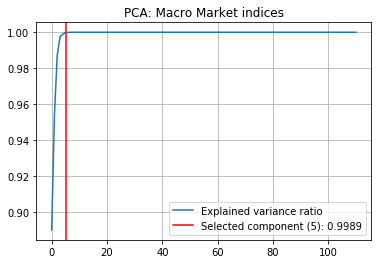

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_.cumsum(), label='Explained variance ratio')
ax.plot([0.9], color='r', label='Selected component (5): 0.9989')
ax.legend()
ax.grid(True)
ax.set_title('PCA: Macro Market indices')
ax.axvline(5, color='r');

In [44]:
components = 5
for i in range(components):
    df_market_data['pca{}'.format(i)] = reduced_market_data[:,i]

In [45]:
agg_funcs = {}

def diff(x):
    return x.iloc[-1] - x.iloc[0]

for i in range(components):
    agg_funcs['pca{}'.format(i)] = ['mean', 'min', 'max', 'std', diff, pd.Series.skew, pd.Series.kurt]

In [46]:
df_market_data_agg = df_market_data.groupby('next_week_start').agg(agg_funcs)
df_market_data_agg = df_market_data_agg.reset_index()

df_market_data_agg.columns = ['_'.join(tup).rstrip('_') for tup in df_market_data_agg.columns.values]

In [47]:
df_market_data_agg.to_csv('data/MarketData_Macro2_ByWeek.csv', index=False)

In [48]:
show_df(df_market_data_agg)

Rows: 176 / Cols: 36


,next_week_start,pca0_mean,pca0_min,pca0_max,pca0_incressing,pca0_skew,pca0_kurt,pca0_std,pca1_mean,pca1_min,...,pca3_skew,pca3_kurt,pca3_std,pca4_mean,pca4_min,pca4_max,pca4_incressing,pca4_skew,pca4_kurt,pca4_std
0,2015-01-05,-2690.385287,-2690.387341,-2690.383233,1.0,NaN,NaN,0.002905,726.120336,726.115076,...,NaN,NaN,0.033377,69.825230,69.812698,69.837762,1.0,NaN,NaN,0.017723
1,2015-01-12,-3065.174223,-3495.255345,-2743.684764,1.0,-0.504131,-1.011598,306.570185,758.609708,573.267802,...,-0.189818,1.814698,135.687263,65.142103,15.409193,126.415571,0.0,0.563230,-0.204279,42.663617
2,2015-01-19,-2780.675358,-2977.708319,-2646.801741,0.0,-0.822696,0.461054,129.838243,1001.834527,854.975952,...,-0.695398,0.503479,175.493093,-111.333109,-152.145408,-34.928734,1.0,1.241838,0.599722,48.566690


# Create dataframe

In [49]:
del df_trade

In [50]:
# df_trade_agg = pd.read_csv('data/Trade2_ByWeek.csv', parse_dates=['week_start'])
# df_trade_agg = df_trade_agg[df_trade_agg.week_start.dt.year >= 2018]

In [51]:
# df_customer = pd.read_csv('data/Customer2.csv')
# df_isin = pd.read_csv('data/Isin2.csv', parse_dates=['week_start'])
# df_market_data_agg = pd.read_csv('data/MarketData_Macro2_ByWeek.csv', parse_dates=['week_start'])
# df_trade_hist = pd.read_csv('data/Trade2_AggHist.csv', parse_dates=['week_start'])
# df_trade_hist2 = pd.read_csv('data/Trade2_AggHistByCustomer.csv', parse_dates=['week_start'])
# df_trade_hist3 = pd.read_csv('data/Trade2_AggHistByIsin.csv', parse_dates=['week_start'])

In [52]:
df_trade_final = pd.merge(df_trade_agg, df_customer, 'left', on='CustomerIdx')
df_trade_final = pd.merge(df_trade_final, df_isin, 'left', on='IsinIdx')
df_trade_final = pd.merge(df_trade_final, df_market_data_agg, 'left',
                          left_on='week_start', right_on='next_week_start')
df_trade_final = pd.merge(df_trade_final, df_trade_hist, 'left',
                          left_on=['CustomerIdx', 'IsinIdx', 'week_start'],
                          right_on=['CustomerIdx', 'IsinIdx', 'next_week_start'],
                          suffixes=('', '_tmp'))
df_trade_final.drop(columns=['week_start_tmp', 'next_week_start_tmp'], inplace=True) 
df_trade_final = pd.merge(df_trade_final, df_trade_hist2, 'left',
                          left_on=['CustomerIdx', 'week_start'],
                          right_on=['CustomerIdx', 'next_week_start'],
                          suffixes=('', '_ByCustomer'))
df_trade_final.drop(columns=['week_start_ByCustomer', 'next_week_start_ByCustomer'], inplace=True)
df_trade_final = pd.merge(df_trade_final, df_trade_hist3, 'left',
                          left_on=['IsinIdx', 'week_start'],
                          right_on=['IsinIdx', 'next_week_start'],
                          suffixes=('', '_ByIsin'))
df_trade_final.drop(columns=['week_start_ByIsin', 'next_week_start_ByIsin'], inplace=True)

df_trade_final.shape

(1477183, 92)

In [53]:
#df_challenge = pd.read_csv('data/Challenge2.csv')

In [54]:
df_challenge_final = pd.merge(df_challenge, df_customer, 'left', on='CustomerIdx')
df_challenge_final = pd.merge(df_challenge_final, df_isin, 'left', on='IsinIdx')
df_challenge_final = pd.merge(df_challenge_final, df_market_data_agg, 'left',
                              left_on='week_start', right_on='next_week_start')
df_challenge_final = pd.merge(df_challenge_final, df_trade_hist, 'left',
                          left_on=['CustomerIdx', 'IsinIdx', 'week_start'],
                          right_on=['CustomerIdx', 'IsinIdx', 'next_week_start'],
                          suffixes=('', '_tmp'))
df_challenge_final.drop(columns=['week_start_tmp', 'next_week_start_tmp'], inplace=True) 
df_challenge_final = pd.merge(df_challenge_final, df_trade_hist2, 'left',
                          left_on=['CustomerIdx', 'week_start'],
                          right_on=['CustomerIdx', 'next_week_start'],
                          suffixes=('', '_ByCustomer'))
df_challenge_final.drop(columns=['week_start_ByCustomer', 'next_week_start_ByCustomer'], inplace=True)
df_challenge_final = pd.merge(df_challenge_final, df_trade_hist3, 'left',
                          left_on=['IsinIdx', 'week_start'],
                          right_on=['IsinIdx', 'next_week_start'],
                          suffixes=('', '_ByIsin'))
df_challenge_final.drop(columns=['week_start_ByIsin', 'next_week_start_ByIsin'], inplace=True)

df_challenge_final.shape

(484758, 94)

### Release Memory

In [55]:
del df_trade_agg
del df_challenge
del df_customer
del df_isin
del df_market
del df_market_data
del df_market_data_agg

### Features

In [56]:
df_trade_final['all_period'] = (df_trade_final.ActualMaturityDateKey - df_trade_final.IssueDateKey).dt.days
df_trade_final['past_period'] = (df_trade_final.week_start - df_trade_final.IssueDateKey).dt.days
df_trade_final['remaining_period'] = (df_trade_final.ActualMaturityDateKey - df_trade_final.week_start).dt.days

In [57]:
df_challenge_final['all_period'] = (df_challenge_final.ActualMaturityDateKey - df_challenge_final.IssueDateKey).dt.days
df_challenge_final['past_period'] = (df_challenge_final.DateKey - df_challenge_final.IssueDateKey).dt.days
df_challenge_final['remaining_period'] = (df_challenge_final.ActualMaturityDateKey - df_challenge_final.DateKey).dt.days

In [58]:
print('Duração:', datetime.now() - start)

Duração: 0:08:11.192244


In [59]:
df_challenge_final.to_pickle('df_challenge_final.pkl')

In [60]:
df_trade_final.to_pickle('df_trade_final.pkl')

### Treat NaN

In [61]:
for column in df_trade_final.columns:
    if df_trade_final[column].dtype == np.object:
        df_trade_final[column].fillna('', inplace=True)
    else:
        df_trade_final[column].fillna(0, inplace=True)
        
for column in df_challenge_final.columns:
    if df_challenge_final[column].dtype == np.object:
        df_challenge_final[column].fillna('', inplace=True)
    else:
        df_challenge_final[column].fillna(0, inplace=True)

### Treat Categorical

In [63]:
%%time
from sklearn.preprocessing import LabelEncoder


def encode_string_columns(df_train, df_test):
    encoded_columns = []
    for column in df_test.columns.drop('PredictionIdx'):
        try:
            if df_test[column].dtype == np.object:
                train_values = list(df_train[column].unique())
                test_values = list(df_test[column].unique())
                encoder = LabelEncoder()
                encoder.fit(np.unique(train_values + test_values))
                df_train[column] = encoder.transform(df_train[column].values)
                df_test[column] = encoder.transform(df_test[column].values)
                encoded_columns.append(column)
        except TypeError as ex:
            print(column)
            raise ex
    return encoded_columns

encode_string_columns(df_trade_final, df_challenge_final)

CPU times: user 31.1 s, sys: 1.41 s, total: 32.5 s
Wall time: 26 s


In [64]:
show_df(df_trade_final)

Rows: 1,477,183 / Cols: 95


,week_start,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Sector,Subsector,Region_x,Country,TickerIdx,...,TradeStatus_NotTraded.sum_ByIsin,TradeStatus_Unknown.sum_ByIsin,ExecutedBuy.sum_ByIsin,ExecutedSell.sum_ByIsin,ExecutedBalance.sum_ByIsin,CustomerIdx.count,CustomerIdx.nunique,all_period,past_period,remaining_period
0,2018-01-01,2,17040,0,1.0,0,21,0,10,238,...,62.0,301.0,272.0,128.0,144.0,696.0,548.0,36524,187,36337
1,2018-01-01,2,17040,1,0.0,0,21,0,10,238,...,62.0,301.0,272.0,128.0,144.0,696.0,548.0,36524,187,36337
2,2018-01-01,9,3428,0,1.0,1,23,1,75,1116,...,44.0,25.0,83.0,116.0,-33.0,437.0,382.0,7305,445,6860


In [65]:
show_df(df_challenge_final)

Rows: 484,758 / Cols: 97


,PredictionIdx,DateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,week_start,Sector,Subsector,Region_x,...,TradeStatus_NotTraded.sum_ByIsin,TradeStatus_Unknown.sum_ByIsin,ExecutedBuy.sum_ByIsin,ExecutedSell.sum_ByIsin,ExecutedBalance.sum_ByIsin,CustomerIdx.count,CustomerIdx.nunique,all_period,past_period,remaining_period
0,a1e0d80784,2018-04-23,1856,13323,0,0.0,2018-04-23,0,22,0,...,5.0,111.0,50.0,66.0,-16.0,381.0,327.0,2923,1866,1057
1,ce7a1e3f46,2018-04-23,703,24709,1,0.0,2018-04-23,2,3,2,...,29.0,29.0,72.0,57.0,15.0,573.0,541.0,2659,696,1963
2,37363eb0b5,2018-04-23,2276,24082,1,0.0,2018-04-23,2,3,2,...,11.0,28.0,48.0,45.0,3.0,431.0,412.0,2922,899,2023


### Save all

In [66]:
df_challenge_final.to_pickle('df_challenge_final.pkl')
del df_challenge_final

In [67]:
df_trade_final.to_pickle('df_trade_final.pkl')
del df_trade_final

In [68]:
print('Duração:', datetime.now() - start)

Duração: 0:08:56.182255
